<a href="https://colab.research.google.com/github/dmytro-varich/Texture-Segmentation-App/blob/main/segmentation_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install PyWavelets

In [3]:
!pip install scikit-learn-extra

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 12.5 MB/s eta 0:00:00


In [5]:
# Standard libraries
import os
from typing import Union, Dict, Tuple, List, Any, Optional

# Third-party libraries
import numpy as np
import matplotlib.pyplot as plt
import imageio
import cv2

# PyWavelet library
import pywt

# skimage libraries
from skimage import io
from skimage.filters.rank import entropy, mean
from skimage.util import img_as_ubyte
from skimage.filters import gaussian
from skimage.util import view_as_windows
from skimage.morphology import closing, opening, square, footprint_rectangle, disk
from skimage.feature import graycomatrix, graycoprops
from skimage.segmentation import chan_vese
from skimage.segmentation import mark_boundaries


# sklearn libraries
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans, kmeans_plusplus, BisectingKMeans, AgglomerativeClustering, DBSCAN, OPTICS
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import rbf_kernel, sigmoid_kernel
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from skimage.feature import hog

# scipy libraries
from scipy.ndimage import median_filter, binary_opening, binary_closing

In [6]:
class FileHandlerMixin:
    """
    A mixin class to provide functionality for loading and saving images.
    """
    @staticmethod
    def load_images(directory: str) -> Dict[str, np.ndarray]:
        """
        Load all images from the specified directory and return them as a dictionary.

        Parameters:
        -----------
        directory : str
            The path to the directory containing images.

        Returns:
        --------
        Dict[str, np.ndarray]
            A dictionary where keys are filenames and values are images.
        """
        images = dict()

        if not os.path.isdir(directory):
            raise ValueError(f"The specified directory '{directory}' does not exist or is not a valid directory.")

        for filename in os.listdir(directory):
            file_path = os.path.join(directory, filename)
            if os.path.isfile(file_path):
                try:
                    image = io.imread(file_path)
                    images[filename] = image
                except Exception as e:
                    print(f"Failed to read '{filename}': {e}")

        return images

    @staticmethod
    def save_segmented_images(directory: str, segmented_images: Dict[str, np.ndarray], tag: str = 'seg') -> None:
        """
        Save segmented images to a specified directory, modifying filenames with a given tag.

        Parameters:
        -----------
        directory : str
            The target directory to save the images.
        segmented_images : Dict[str, np.ndarray]
            A dictionary of filenames and segmented images.
        tag : str, optional, default 'seg'
            The tag to replace 'tg' in filenames.

        Returns:
        --------
        None
        """
        os.makedirs(directory, exist_ok=True)

        for filename, image in segmented_images.items():
            new_filename = filename.replace('tg', tag)
            file_path = os.path.join(directory, new_filename)

            try:
                imageio.imwrite(file_path, image)
            except Exception as e:
                print(f"Error saving image '{new_filename}': {e}")

In [7]:
class ImageVizualizationMixin:
    """
    A mixin class to provide functionality for displaying images.
    """
    @staticmethod
    def show_images(
        images: Dict[str, np.ndarray],
        *,
        rows: int,
        cols: int,
        figsize: Tuple[int, int] = (15, 10),
        cmap: Optional[str],
        show_ax: str = 'on'
    ) -> None:
        # Create a subplot grid with the specified number of rows and columns
        fig, axes = plt.subplots(rows, cols, figsize=figsize)

        # If there is only one axis (for example, when rows=1 and cols=1)
        if rows == 1 and cols == 1:
            axes = [axes]
        else:
          axes = axes.flatten()  # Flattening the axes to 1D array

        # Iterate over the axes and images to display them
        for ax, (title, image) in zip(axes, images.items()):
            # Create a copy of the image for normalization
            img = image * 1
            # Ensure img is a numpy array
            img = np.asarray(img)
            # Normalize the image to the range [0, 255]
            # Modified to handle float32 images with cv2.normalize
            if img.dtype == np.float32:  # Check if dtype is float32
                img = (img * 255).astype(np.uint8) # Scale to 0-255 and convert to uint8
            else:
                cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)  # Existing code for other types
            # Convert the image to uint8 format for display
            img = np.uint8(img)
            # Display the image
            ax.imshow(img, cmap=cmap)
            # Set the title of the image
            ax.set_title(title)
            # Hide or show axes depending on 'show_ax' argument
            ax.axis(show_ax)

        # Adjust layout to make the plot elements fit neatly
        plt.tight_layout()

        # Display the plot
        try:
            plt.show()
        except KeyboardInterrupt:
            pass

    @staticmethod
    def simple_display_image(image: np.ndarray, title: str = 'Image', cmap: str = 'viridis', show_ax: str = 'on') -> None:
      plt.imshow(image, cmap=cmap)
      plt.title(title)
      plt.axis(show_ax)
      plt.show()

In [8]:
class ImagePreprocessingMixin:
    """
    A mixin class to provide functionality for image preprocessing.
    """
    @staticmethod
    def _convert_to_gray(image: np.ndarray) -> np.ndarray:
        """Convert image to grayscale."""
        if len(image.shape) == 3:
            try:
                return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            except Exception as e:
                raise ValueError(f"Failed to convert image to grayscale: {e}")
        return image

    @staticmethod
    def _resize_image(image: np.ndarray, size: Tuple[int, int]) -> np.ndarray:
        """Resize the image to the specified dimensions."""
        return cv2.resize(image, size, interpolation=cv2.INTER_NEAREST)

    @staticmethod
    def _normalize_image(image: np.ndarray) -> np.ndarray:
        """Normalize the image to the range [0, 1]."""
        if image.dtype != np.float32:
            image = image.astype(np.float32) / 255.0
        return image

    @staticmethod
    def _apply_gaussian_blur(image: np.ndarray, sigma: float) -> np.ndarray:
        """Apply Gaussian blur."""
        blurred = gaussian(image, sigma=sigma)
        return cv2.normalize(blurred, None, alpha=0, beta=1,
                             norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

    @staticmethod
    def _clip_range(image: np.ndarray, clip_range: Tuple[int, int] = (0, 1)) -> np.ndarray:
        """Clip the image to the specified range."""
        return np.clip(image, clip_range[0], clip_range[1])

In [9]:
class TextureFeatureExtractorMixin:
    """
    A mixin class to provide functionality for texture feature extraction.
    """

    @staticmethod
    def _ensure_normalized(image: np.ndarray) -> np.ndarray:
        """Ensure the image is normalized to the range [0, 1]."""
        if image.max() > 1.0 or image.min() < 0.0:
            return image.astype(np.float32) / 255.0
        return image

    @staticmethod
    def apply_wavelet_transform(image: np.ndarray, wavelet: str = 'haar', level: int = 2) -> np.ndarray:
        """Apply Wavelet transform."""
        image = TextureFeatureExtractorMixin._ensure_normalized(image)
        coeffs = pywt.wavedec2(image, wavelet=wavelet, level=level)
        LL = coeffs[0]
        coeffs_filtered = [LL] + [(None, None, None) for _ in range(level)]
        wavelet_reconstructed = pywt.waverec2(coeffs_filtered, wavelet=wavelet)

        wavelet_normalized = cv2.normalize(
            wavelet_reconstructed, None, alpha=0, beta=1,
            norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F
        )

        return wavelet_normalized

    @staticmethod
    def apply_fourier_transform(
        image: np.ndarray,
        radius_out: int = 100,
        radius_in: int = 10,
    ) -> np.ndarray:
        """Apply Fourier Transform with bandpass filtering."""
        image = TextureFeatureExtractorMixin._ensure_normalized(image)

        if image.ndim != 2:
            raise ValueError("Input image must be a grayscale 2D array.")

        # Step 1: Compute the Discrete Fourier Transform
        dft = cv2.dft(np.float32(image), flags=cv2.DFT_COMPLEX_OUTPUT)
        dft_shift = np.fft.fftshift(dft)

        # Step 2: Create a bandpass filter mask
        rows, cols = image.shape
        crow, ccol = rows // 2, cols // 2  # Center of the image

        mask = np.zeros((rows, cols, 2), np.uint8)
        x, y = np.ogrid[:rows, :cols]
        center = [crow, ccol]
        mask_area = np.logical_and(
            ((x - center[0]) ** 2 + (y - center[1]) ** 2 >= radius_in ** 2),
            ((x - center[0]) ** 2 + (y - center[1]) ** 2 <= radius_out ** 2)
        )
        mask[mask_area] = 1

        # Step 3: Apply the mask to the Fourier transform
        fshift = dft_shift * mask

        # Step 4: Perform the inverse Fourier Transform
        f_ishift = np.fft.ifftshift(fshift)
        img_back = cv2.idft(f_ishift)
        img_back = cv2.magnitude(img_back[:, :, 0], img_back[:, :, 1])
        img_normalized = cv2.normalize(img_back, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

        return img_normalized

    @staticmethod
    def apply_entropy_filter(image: np.ndarray, window_size: int = 4) -> np.ndarray:
        """Compute entropy in a local neighborhood and normalize the result."""
        image = TextureFeatureExtractorMixin._ensure_normalized(image)
        image_uint8 = img_as_ubyte(image)
        entropy_map = entropy(image_uint8, disk(window_size))
        return cv2.normalize(entropy_map, None, alpha=0, beta=1,
                            norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

    @staticmethod
    def apply_mean_filter(image: np.ndarray, window_size: int = 4) -> np.ndarray:
        """Compute mean in a local neighborhood and normalize the result."""
        image = TextureFeatureExtractorMixin._ensure_normalized(image)
        image_uint8 = img_as_ubyte(image)
        mean_map = mean(image_uint8, disk(window_size))
        return cv2.normalize(mean_map, None, alpha=0, beta=1,
                            norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

    @staticmethod
    def apply_laplacian_filter(image: np.ndarray) -> np.ndarray:
        """Apply Laplacian operator and normalize the result."""
        image = TextureFeatureExtractorMixin._ensure_normalized(image)
        laplacian_map = cv2.Laplacian(image, cv2.CV_32F)
        return cv2.normalize(laplacian_map, None, alpha=0, beta=1,
                            norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

In [10]:
class ImagePostProcessingMixin:
    """
    A mixin class to provide functionality for image post-processing.
    """
    @staticmethod
    def apply_median_filter(image: np.ndarray, size: int) -> np.ndarray:
        return median_filter(image, size=size)

    @staticmethod
    def apply_opening(image: np.ndarray, size: int) -> np.ndarray:
        return opening(image, disk(size))

    @staticmethod
    def apply_closing(image: np.ndarray, size: int) -> np.ndarray:
        return closing(image, disk(size))

In [30]:
class TextureSegmentation(FileHandlerMixin, ImageVizualizationMixin, ImagePreprocessingMixin, TextureFeatureExtractorMixin, ImagePostProcessingMixin):
    """"""
    @staticmethod
    def preprocess_image(
        image: np.ndarray,
        *,
        resize_shape: Tuple[int, int] = None,
        convert_to_gray: bool = True,
        normalize: bool = True,
        sigma: Optional[float] = None,
        clip_range: Tuple[int, int] = (0, 1)
    ) -> np.ndarray:
        if not isinstance(image, np.ndarray):
            raise ValueError("Input must be a NumPy array")

        if convert_to_gray:
            image = TextureSegmentation._convert_to_gray(image)

        if resize_shape:
            image = TextureSegmentation._resize_image(image, resize_shape)

        if normalize:
            image = TextureSegmentation._normalize_image(image)

        if sigma:
            image = TextureSegmentation._apply_gaussian_blur(image, sigma)

        if clip_range and (image.min() < clip_range[0] or image.max() > clip_range[1]):
            image = TextureSegmentation._clip_range(image, clip_range)

        return image

    @staticmethod
    def extract_patches(image: np.ndarray, patch_size: Tuple[int, int] = (7, 7), patch_step: int = 1) -> np.ndarray:
        try:
            if isinstance(patch_size, tuple) and len(patch_size) == 2:
                patches = view_as_windows(image, patch_size, step=patch_step)
                patches = patches.reshape(-1, patch_size[0], patch_size[1])
            else:
                raise ValueError("patch_size must be an int or a tuple of length 2")
        except Exception as e:
            raise RuntimeError(f"Error extracting patches: {e}")

        return patches

    @staticmethod
    def cluster_patches(
        patches: np.ndarray,
        max_clusters: int = 50,
        *,
        find_optimal_clusters: Optional[bool] = False
    ) -> Tuple[np.ndarray, int]:
        kmeans = KMeans(n_clusters=max_clusters, random_state=0)
        kmeans.fit(patches)
        cluster_centroids = kmeans.cluster_centers_

        cluster_centroids = np.clip(cluster_centroids, 0, 1)

        return cluster_centroids, max_clusters

    @staticmethod
    def compute_texture_features(
        image: np.ndarray,
        prp_centroids: np.ndarray,
        filters: dict,
        *,
        patch_size: Tuple[int, int] = (7, 7),
        patch_step: int = 1,
        sigma: float = 1.0,  # Standard deviation of Gaussian kernel
        h: float = 1.0,  # smooth factor
        threshold: float = 0.1
    ) -> np.ndarray:
        # Get image dimensions
        height, width = image.shape

        # Initialize array to store texture features
        texture_features = np.zeros((height, width))

        # Initialize list to store reshaped patches
        all_patches = []

        # Loop over each feature and apply corresponding filter from the filters dict
        for feature_name, filtered_image in filters.items():
            # Extract patches for the current feature
            feature_patches = TextureSegmentation.extract_patches(filtered_image, patch_size, patch_step)

            # Reshape patches into a 2D array
            feature_patches_reshaped = feature_patches.reshape(feature_patches.shape[0], -1)

            # Append the reshaped patches to the list
            all_patches.append(feature_patches_reshaped)

        # Stack all patches into a single matrix
        patch_vectors = np.hstack(all_patches)

        # Reshape PRP centroids
        prp_centroids = prp_centroids.reshape(prp_centroids.shape[0], -1)

        # Calculate similarities using the exact formula from the paper
        def calculate_similarities(patches, centroids, sigma, h, threshold=0.1):
          squared_dists = np.sum((patches[:, np.newaxis, :] - centroids[np.newaxis, :, :]) ** 2, axis=2)
          similarities = np.exp(-squared_dists / (h * h * sigma * sigma))
          Z = similarities.sum(axis=1, keepdims=True)
          probabilities = similarities / np.where(Z > 0, Z, 1)

          # Обнуляем вероятности ниже порога
          probabilities[probabilities < threshold] = 0
          # Перенормируем
          row_sums = probabilities.sum(axis=1, keepdims=True)
          probabilities = np.divide(probabilities, row_sums, where=row_sums > 0)

          return probabilities

        probabilities = calculate_similarities(patch_vectors, prp_centroids, sigma, h, threshold)

        # Average probabilities across all patches for each PRP
        mean_probabilities = np.mean(probabilities, axis=0)
        contrast_weights = np.abs(probabilities - mean_probabilities)  # Difference from global mean
        contrast_weights /= contrast_weights.sum(axis=1, keepdims=True)

        # Update probabilities with contrast weights
        enhanced_probabilities = probabilities * contrast_weights

        # Get cluster assignments
        cluster_assignments = np.argmax(enhanced_probabilities, axis=1)

        # Map the results back to the image dimensions
        n_patches_h = (height - patch_size[0]) // patch_step + 1
        n_patches_w = (width - patch_size[1]) // patch_step + 1
        offset_h = patch_size[0] // 2
        offset_w = patch_size[1] // 2
        for idx, cluster in enumerate(cluster_assignments):
            row_start = (idx // n_patches_w) * patch_step
            col_start = (idx % n_patches_w) * patch_step

            texture_features[row_start:row_start + patch_size[0], col_start:col_start + patch_size[1]] = cluster

        return texture_features

    @staticmethod
    def assign_labels(segmented_image: np.ndarray) -> np.ndarray:
        # Преобразуем изображение в целочисленный тип
        segmented_image = np.round(segmented_image).astype(int)

        # Получаем уникальные метки
        labels = np.unique(segmented_image)

        # Создаем отображение оригинальных меток в новые метки
        label_mapping = {original: new for new, original in enumerate(labels)}

        # Преобразуем изображение, используя индексирование NumPy
        normalized_image = np.searchsorted(labels, segmented_image)

        return normalized_image

    @staticmethod
    def segmentation(
        image: np.ndarray,
        prp_centroids: np.ndarray,
        filters: dict,
        *,
        patch_size: Tuple[int, int] = (7, 7),
        patch_step: int = 1,
        sigma: float = 1.0,
        h: float = 1.0,
        threshold: float = 0.1
    ) -> Tuple[np.ndarray, np.ndarray]:
        # Compute texture features
        texture_map = TextureSegmentation.compute_texture_features(
            image, prp_centroids, filters, patch_size=patch_size, patch_step=patch_step, sigma=sigma, h=h, threshold=threshold
        )
        segmented_image = TextureSegmentation.assign_labels(texture_map)

        edge = mark_boundaries(image, segmented_image)

        return segmented_image, edge

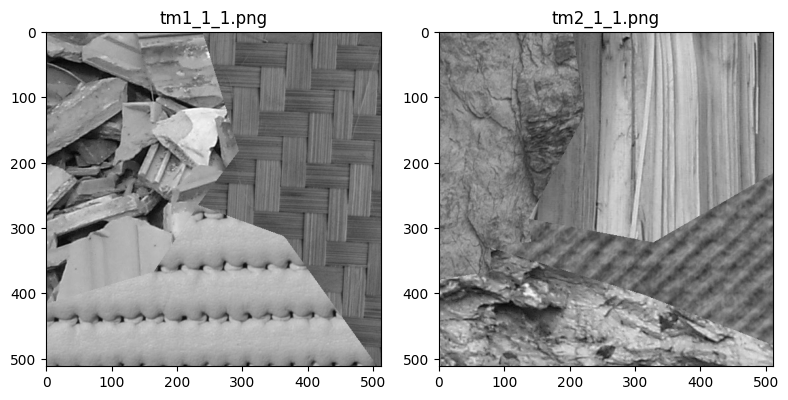

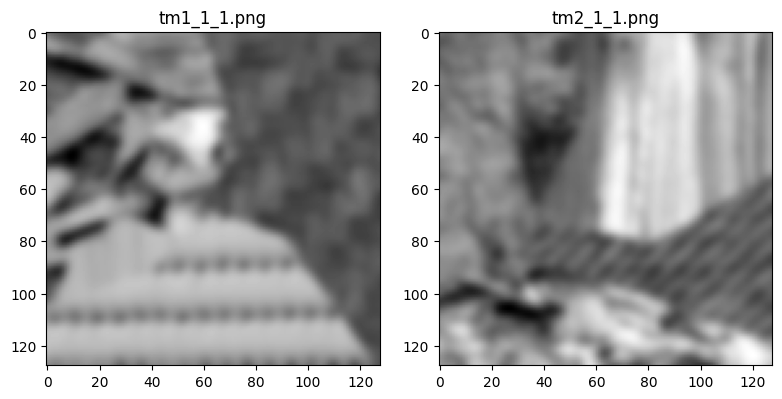

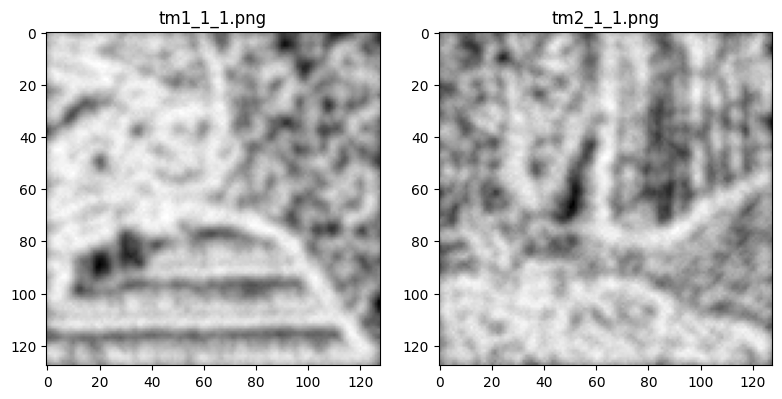

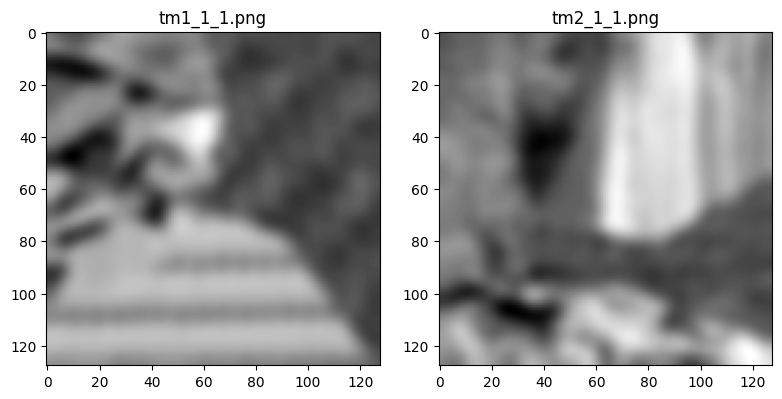

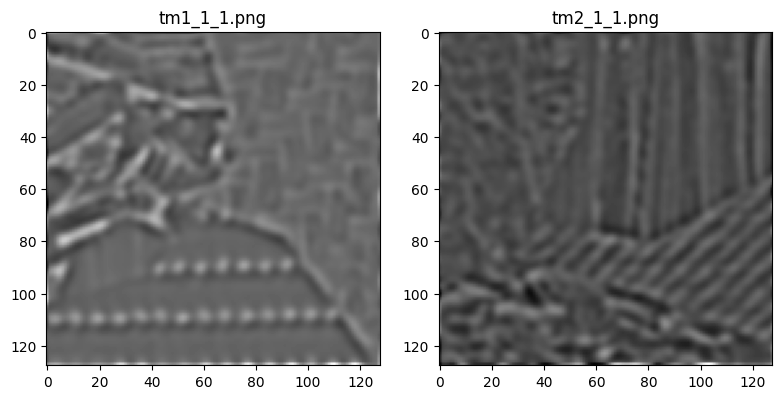

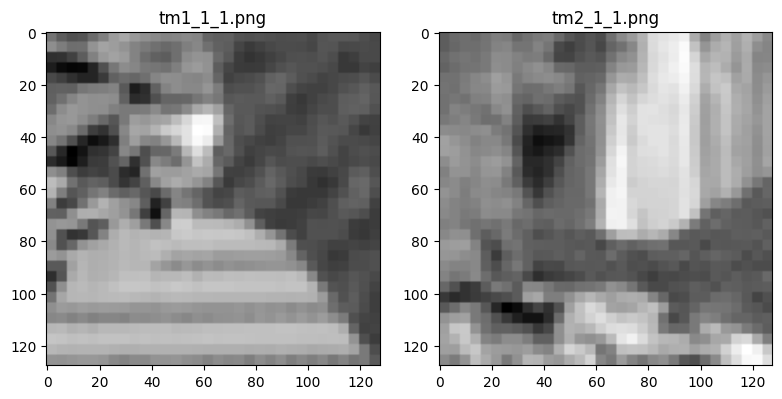

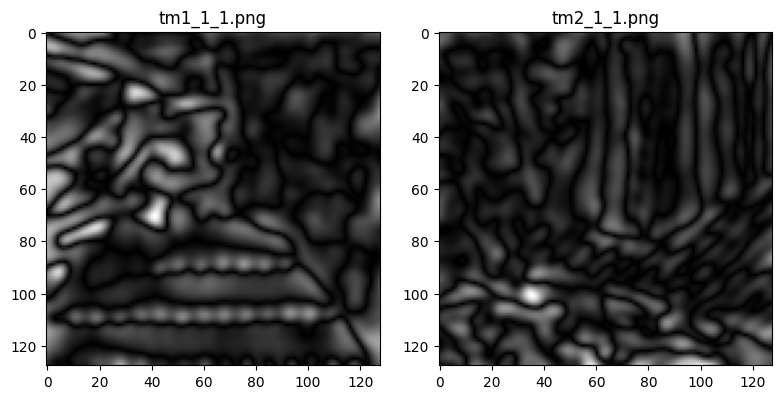

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
<ipython-input-30-628c9bdf0a0f>:119: RuntimeWarning: invalid value encountered in divide
  contrast_weights /= contrast_weights.sum(axis=1, keepdims=True)


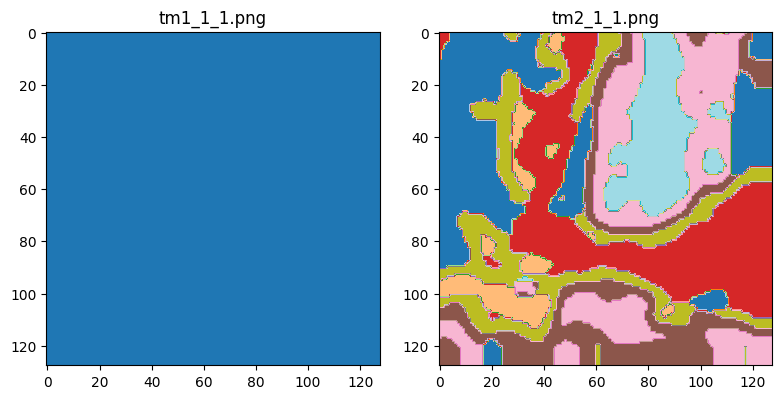

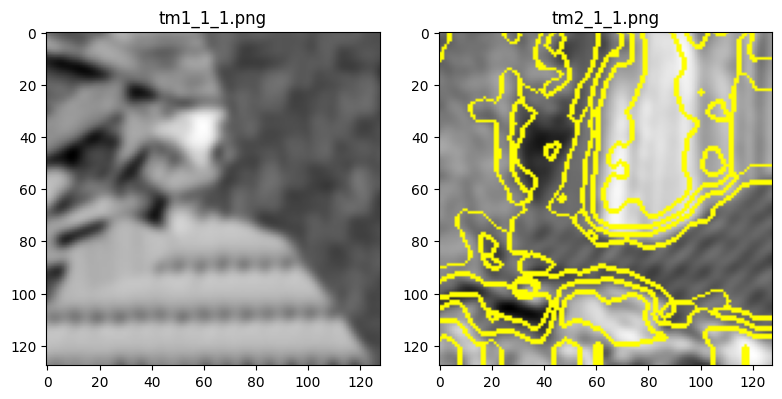

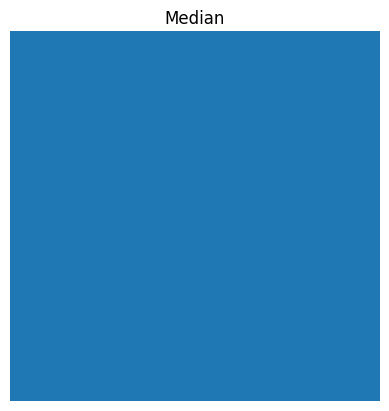

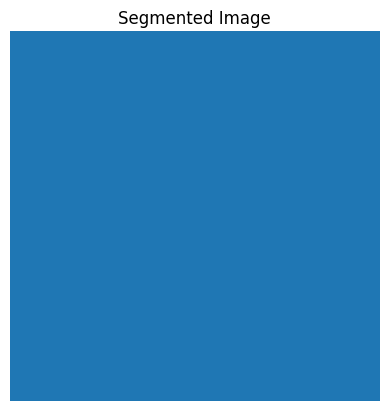

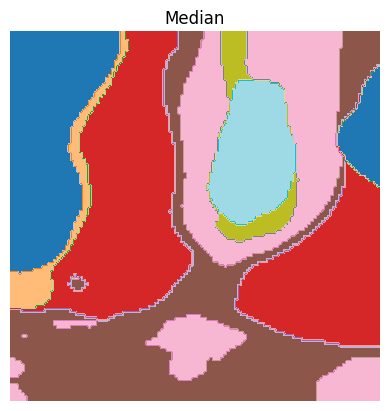

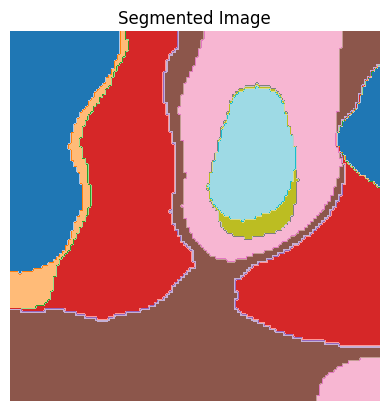

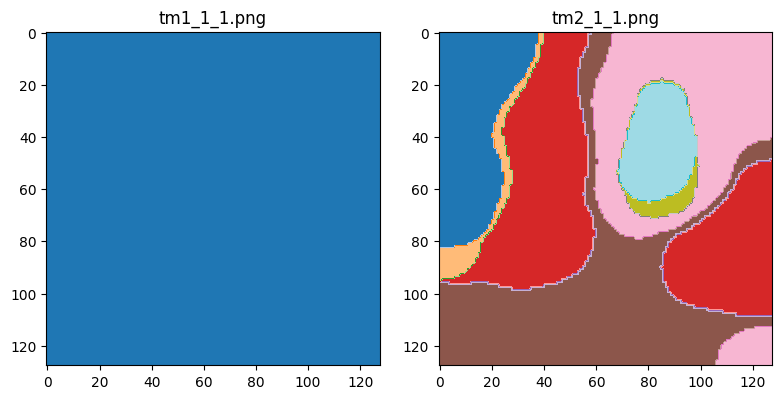

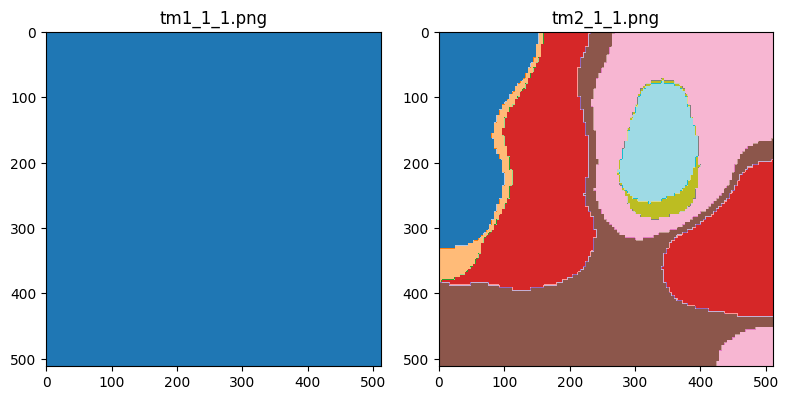

In [31]:
def main(directory):
    # Load images from the specified directory
    images: dict = TextureSegmentation.load_images(directory)

    # Display the images
    rows, cols, figsize = 1, 2, (8, 6)
    TextureSegmentation.show_images(images, rows=rows, cols=cols, figsize=figsize, cmap='gray')

    # Preprocess images
    resize_shape = (128, 128)
    convert_to_gray = True
    normalize = True
    sigma = 2.0
    clip_range = (0, 1)
    for key, image in images.items():
        images[key] = TextureSegmentation.preprocess_image(image,
                                                           resize_shape=resize_shape,
                                                           convert_to_gray=convert_to_gray,
                                                           normalize=normalize,
                                                           sigma=sigma,
                                                           clip_range=clip_range)

    # Display the preprocessed images
    TextureSegmentation.show_images(images, rows=rows, cols=cols, figsize=figsize, cmap='gray')

    # Texture feature extraction
    entropy_images, mean_images, laplacian_images = dict(), dict(), dict()
    wavelet_images, fourier_images = dict(), dict()
    window_size = 4
    wavelet = 'haar'
    wavelet_level = 2
    radius_out = 100
    radius_in = 5
    for key, image in images.items():
        entropy_images[key] = TextureSegmentation.apply_entropy_filter(image, window_size)
        mean_images[key] = TextureSegmentation.apply_mean_filter(image, window_size)
        laplacian_images[key] = TextureSegmentation.apply_laplacian_filter(image)
        wavelet_images[key] = TextureSegmentation.apply_wavelet_transform(image, wavelet, wavelet_level)
        fourier_images[key] = TextureSegmentation.apply_fourier_transform(image, radius_out, radius_in)

    # Visualization of extracted texture features
    TextureSegmentation.show_images(entropy_images, rows=rows, cols=cols, figsize=figsize, cmap='gray')
    TextureSegmentation.show_images(mean_images, rows=rows, cols=cols, figsize=figsize, cmap='gray')
    TextureSegmentation.show_images(laplacian_images, rows=rows, cols=cols, figsize=figsize, cmap='gray')
    TextureSegmentation.show_images(wavelet_images, rows=rows, cols=cols, figsize=figsize, cmap='gray')
    TextureSegmentation.show_images(fourier_images, rows=rows, cols=cols, figsize=figsize, cmap='gray')

    # Extract patches from the extracted texture features
    patch_size = (7, 7)
    patch_step = 1
    all_patches = []
    for key in images.keys():
      # Extract patches for each texture feature
      entropy_patch = TextureSegmentation.extract_patches(entropy_images[key], patch_size=patch_size, patch_step=patch_step)
      mean_patch = TextureSegmentation.extract_patches(mean_images[key], patch_size=patch_size, patch_step=patch_step)
      laplacian_patch = TextureSegmentation.extract_patches(laplacian_images[key], patch_size=patch_size, patch_step=patch_step)
      wavelet_patch = TextureSegmentation.extract_patches(wavelet_images[key], patch_size=patch_size, patch_step=patch_step)
      fourier_patch = TextureSegmentation.extract_patches(fourier_images[key], patch_size=patch_size, patch_step=patch_step)

      # Reshape patches into 2D arrays (each row is a flattened patch)
      entropy_patch = entropy_patch.reshape(-1, patch_size[0] * patch_size[1])
      mean_patch = mean_patch.reshape(-1, patch_size[0] * patch_size[1])
      laplacian_patch = laplacian_patch.reshape(-1, patch_size[0] * patch_size[1])
      wavelet_patch = wavelet_patch.reshape(-1, patch_size[0] * patch_size[1])
      fourier_patch = fourier_patch.reshape(-1, patch_size[0] * patch_size[1])

      # Combine patches for the current image into a single array
      combined = np.hstack([entropy_patch, mean_patch, laplacian_patch, wavelet_patch, fourier_patch])

      # Append combined patches for this image
      all_patches.append(combined)

    # Stack all combined patches into a single array
    all_patches = np.vstack(all_patches)  # Shape: (total_patches, features_per_patch)

    # Cluster patches to find PRP (Principal Representative Patterns)
    max_clusters = 7
    prp_centroids, optimal_clusters = TextureSegmentation.cluster_patches(all_patches,
                                                                          max_clusters=max_clusters,
                                                                          find_optimal_clusters=False)

    # Segment the images by extracting texture features and using
    segmented_images, edges = dict(), dict()
    sigma = 0.3
    h = 1.0
    threshold = 0.1
    for key, image in images.items():
        # Create a filters dictionary
        filters = {
            'entropy': entropy_images[key],
            'mean': mean_images[key],
            'laplacian': laplacian_images[key],
            'wavelet': wavelet_images[key],
            'fourier': fourier_images[key]
        }
        segmented_images[key], edges[key] = TextureSegmentation.segmentation(image, prp_centroids, filters,
                                                                            patch_size=patch_size,
                                                                            patch_step=patch_step,
                                                                            sigma=sigma, h=h, threshold=threshold)

    # Display the segmented images and edges
    TextureSegmentation.show_images(segmented_images, figsize=figsize, rows=rows, cols=cols, cmap='tab20')
    TextureSegmentation.show_images(edges, figsize=figsize, rows=rows, cols=cols, cmap='jet')

    # Postprocess the labled images
    postprocessed_images = dict()
    median_filter_size = 30
    opening_size = 10
    closing_size = 15
    for key, segmented_image in segmented_images.items():
      postprocessed_images[key] = TextureSegmentation.apply_median_filter(segmented_image, median_filter_size)
      TextureSegmentation.simple_display_image(postprocessed_images[key], title='Median', cmap='tab20', show_ax = 'off')
      postprocessed_images[key] = TextureSegmentation.apply_opening(postprocessed_images[key], opening_size)
      TextureSegmentation.simple_display_image(postprocessed_images[key], title='Segmented Image', cmap='tab20', show_ax = 'off')
      postprocessed_images[key] = TextureSegmentation.apply_closing(postprocessed_images[key], closing_size)

    # Display the postprocessed images
    TextureSegmentation.show_images(postprocessed_images, figsize=figsize, rows=rows, cols=cols, cmap='tab20')

    # Resize
    result_images = dict()
    resize_shape = (512, 512)
    for key, postprocessed_image in postprocessed_images.items():
        result_images[key] = TextureSegmentation.preprocess_image(postprocessed_image,
                                                                  resize_shape=resize_shape)

    # Display the postprocessed images
    TextureSegmentation.show_images(result_images, figsize=figsize, rows=rows, cols=cols, cmap='tab20')

    # Save the segmented images to the output directory
    # TextureSegmantation.save_segmented_images('output', postprocessed_images)

if __name__ == '__main__':
    directory = 'data/'
    main(directory)